# References

In [133]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from fastai.conv_learner import *
from fastai.dataset import *

import pdb
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
import pandas as pd
import matplotlib.pyplot as plt
import pydicom
import numpy as np
from pathlib import Path
from glob import glob
torch.cuda.set_device(0)
torch.backends.cudnn.benchmark=True

# Global Variables

In [24]:
dp = Path('../../datasets/RSNA_PDC/')

# Data Exploration

## Paths 

In [54]:
list(dp.iterdir())

[PosixPath('../../datasets/RSNA_PDC/stage_1_test_images'),
 PosixPath('../../datasets/RSNA_PDC/stage_1_detailed_class_info.csv'),
 PosixPath('../../datasets/RSNA_PDC/stage_1_sample_submission.csv'),
 PosixPath('../../datasets/RSNA_PDC/GCP Credits Request Link - RSNA.txt'),
 PosixPath('../../datasets/RSNA_PDC/.ipynb_checkpoints'),
 PosixPath('../../datasets/RSNA_PDC/stage_1_train_images'),
 PosixPath('../../datasets/RSNA_PDC/stage_1_train_labels.csv')]

In [121]:
s1_dci, s1_ssub, s1_tls, images = ['stage_1_detailed_class_info.csv', 'stage_1_sample_submission.csv', 'stage_1_train_labels.csv', 'stage_1_train_images']

## Detailed class info csv file

In [75]:
dci_df = pandas.read_csv(dp/s1_dci)
print(dci_df.shape[0])
dci_df[:5]

28989


,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


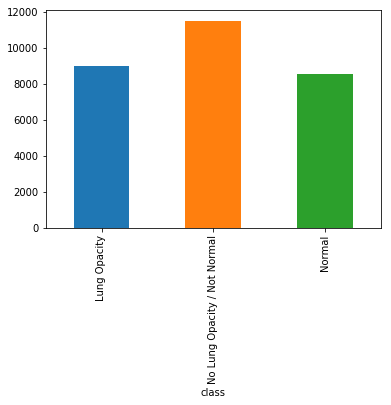

In [57]:
dci_df.groupby('class').size().plot.bar()

## Bounding boxes csv file

In [65]:
bbox_df = pd.read_csv(dp/s1_tls)
bbox_df[:5]

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


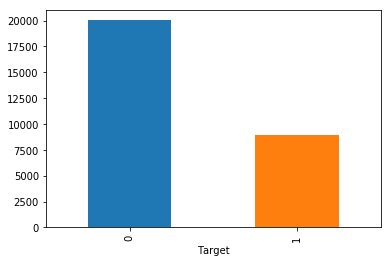

In [66]:
bbox_df.groupby('Target').size().plot.bar()

## Combine boxes and labels 

In [72]:
comb_bbox_df = pd.concat([bbox_df, 
                        dci_df.drop('patientId',1)], 1)
print(comb_bbox_df.shape[0], 'combined cases')
comb_bbox_df[:5]

28989 combined cases


,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


## Distribution of boxes per patient

In [117]:
box_df = comb_bbox_df.groupby('patientId')['x'].count().reset_index(name='boxes')
box_df
comb_box_df = pd.merge(comb_bbox_df, box_df, on='patientId')
box_df.groupby('boxes').size().reset_index(name='patients')

,boxes,patients
0,0,20025
1,1,2481
2,2,3062
3,3,105
4,4,11


## Relation of class and target

In [119]:
comb_bbox_df.groupby(['class', 'Target']).size().reset_index(name='Patient Count')

,class,Target,Patient Count
0,Lung Opacity,1,8964
1,No Lung Opacity / Not Normal,0,11500
2,Normal,0,8525


##  Images

In [145]:
image_df = pd.DataFrame({'path' : glob(os.path.join(dp/images, '*.dcm'))})
image_df

,path
0,../../datasets/RSNA_PDC/stage_1_train_images/c...
1,../../datasets/RSNA_PDC/stage_1_train_images/8...
2,../../datasets/RSNA_PDC/stage_1_train_images/8...
3,../../datasets/RSNA_PDC/stage_1_train_images/b...
4,../../datasets/RSNA_PDC/stage_1_train_images/4...
5,../../datasets/RSNA_PDC/stage_1_train_images/c...
6,../../datasets/RSNA_PDC/stage_1_train_images/7...
7,../../datasets/RSNA_PDC/stage_1_train_images/7...
8,../../datasets/RSNA_PDC/stage_1_train_images/2...
9,../../datasets/RSNA_PDC/stage_1_train_images/7...


In [147]:
image_df['patientId'] = image_df['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
image_df

,path,patientId
0,../../datasets/RSNA_PDC/stage_1_train_images/c...,c574be57-1288-4b87-940f-5c45be1fddce
1,../../datasets/RSNA_PDC/stage_1_train_images/8...,8570eacc-7d96-40b8-9be9-11a7b56db4c7
2,../../datasets/RSNA_PDC/stage_1_train_images/8...,863a923a-3906-42d3-92db-76c900091fce
3,../../datasets/RSNA_PDC/stage_1_train_images/b...,bf7bc9a6-d454-4edd-8752-9273448a3b10
4,../../datasets/RSNA_PDC/stage_1_train_images/4...,49c413cc-e806-4bc4-b744-1987261282c1
5,../../datasets/RSNA_PDC/stage_1_train_images/c...,c3fd576c-20f1-4d10-a96f-8cea38100bb3
6,../../datasets/RSNA_PDC/stage_1_train_images/7...,7cec580b-d147-4f31-8e2b-41ffe8c940c7
7,../../datasets/RSNA_PDC/stage_1_train_images/7...,7464e292-ecd7-4806-957d-dbab928c9579
8,../../datasets/RSNA_PDC/stage_1_train_images/2...,2eb0a283-bb6d-48ef-9c11-a0924f32e67b
9,../../datasets/RSNA_PDC/stage_1_train_images/7...,7ce31482-fdad-4830-96a8-1a6ac96c544d


In [155]:
print(image_df.shape[0], 'images found')

25684 images found
